![](img/563_banner.png)

# Lecture 4: More PCA, LSA, and NMF

UBC Master of Data Science program, 2021-22

Instructor: Varada Kolhatkar

## Lecture plan and learning outcomes

### Lecture plan 

- Announcements 
- PCA recap and choosing $k$ (~20 mins)
- Other miscellaneous PCA stuff (~10 mins)
- Q&A and T/F questions (~5 mins)
- Break (~5 mins)
- TruncatedSVD or LSA (~20 mins)
- NMF (~10 mins)
- Q&A and T/F questions (~5 mins)
- Final comments and summary (~5 mins)

### Imports 

In [1]:
import os
import random
import sys
import time

import numpy as np

sys.path.append("code/.")
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from plotting_functions import *
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from support_functions import *

plt.rcParams["font.size"] = 16

from sklearn.datasets import fetch_lfw_people

# plt.style.use("seaborn")
%matplotlib inline
pd.set_option("display.max_colwidth", 0)

### Learning outcomes

From this lecture, students are expected to be able to:


- Explain how to write a training example as a linear combination of components, in the context of PCA;   
- Use `explained_variance_ratio_` of PCA to choose $k$ in the context of dimensionality reduction using PCA. 
- Explain the geometry of PCA for different values for $n$ and $d$. 
- Explain similarities and differences between K-Means and PCA. 
- State similarities and differences between `PCA`, `TruncatedSVD`, and `NMF`. 
- Interpret components givens given by PCA, Truncated SVD and NMF.  
- Recognize the scenarios for using `TruncatedSVD` and `NMF` and use them with `scikit-learn`. 

<br><br>

## PCA recap

A commonly used dimensionality reduction technique. 

- PCA input
    - $X_{n \times d}$
    - the number of components $k$
- PCA output
    - $W_{k \times d}$ with $k$ principal components (also called "parts")
    - $Z_{n \times k}$ transformed data (also called "part weights")
- Usually $k << d$. 
- PCA is useful for dimensionality reduction, visualization, feature extraction etc.

### Important matrices involved in PCA

PCA learns a $k$-dimensional subspace of the original $d$-dimensional space. Here are the main matrices involved in PCA.  

- $X \rightarrow$ Original data matrix
- $W \rightarrow$ Principal components
    - the best lower-dimensional hyper-plane found by the PCA algorithm
- $Z \rightarrow$ Transformed data with reduced dimensionality
    - the co-ordinates in the lower dimensional space  
- $X_{hat} \rightarrow$ Reconstructed data
    - reconstructions using $Z$ and $W$ in the original co-ordinate system

How can we use $W$ and $Z$? 

- Dimension reduction: compress data into limited number of components.
- Outlier detection: it might be an outlier if isn't a combination of usual components.
- Supervised learning: we could use $Z$ as our features.
- Visualization: if we have only 2 components, we can view data as a scatterplot.
- Interpretation: we can try and figure out what the components represent.

- PCA reduces the dimensionality by learning a $k$-dimensional subspace of the original $d$-dimensional space.
- When going from higher dimensional space to lower dimensional space, PCA still tries to capture the topology of the points in high dimensional space, making sure  that we are not losing some of the important properties of the data. 
- So Points which are nearby in high dimensions are still nearby in low dimension. 

- In PCA, we find a lower dimensional subspace so that the squared error of reconstruction, i.e., elements of $X$ and elements of $ZW$ is minimized. 
- The goal is to find the two best matrices such that when we multiply them we get a matrix that's closest to the data. 
- A common way to learn PCA is using singular value decomposition (SVD). 

### PCA examples

- Let's look at examples of reducing dimensionality using PCA from 3 to 2 and from 3 to 1. 

In [2]:
n = 12
d = 3

x1 = np.linspace(0, 5, n) + np.random.randn(n) * 0.05
x2 = -x1 * 0.1 + np.random.randn(n) * 2
x3 = x1 * 0.7 + np.random.randn(n) * 3

X = np.concatenate((x1[:, None], x2[:, None], x3[:, None]), axis=1)
X = X - np.mean(X, axis=0)

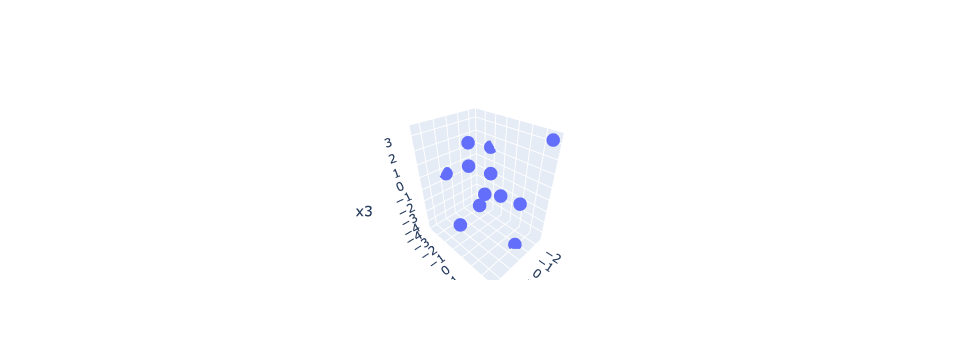

In [3]:
plot_interactive_3d(X)

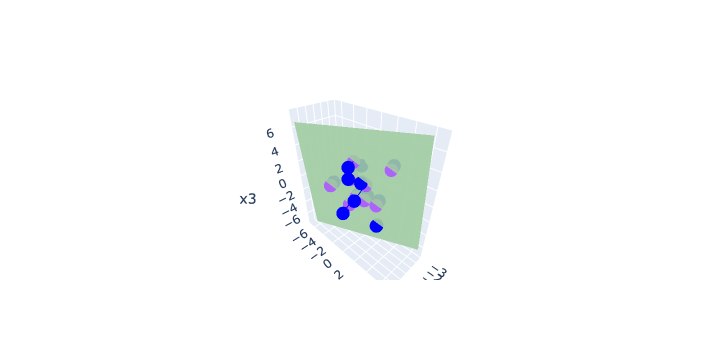

In [4]:
pca = PCA(n_components=2)
pca.fit(X)
plot_2d_1k(X, pca)

- The plane corresponds to $W$. 
- $Z_i$ are the co-ordinates of the $X_i$ projected onto the plane. 
- It gives us projected data in the new 2D coordinate system.
- $X_{hat}$ are reconstructions in the original 3D coordinate system.  

We can also plot the transformed `Z` values in two dimensions. 

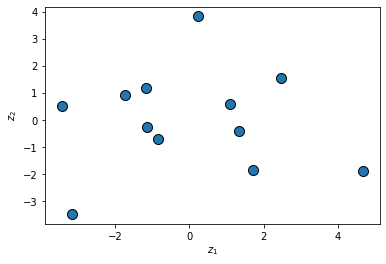

In [5]:
Z = pca.transform(X)
mglearn.discrete_scatter(Z[:, 0], Z[:, 1])
plt.xlabel("$z_1$")
plt.ylabel("$z_2$");

How does this relate to maximum variance view of PCA? 
- To describe a two dimensional plane we need two basis vectors. 
- The first basis vector is in the direction of the maximum variance of the data and the second basis vector is in the second maximum variance in the data. 

### Moving to $d=3,k=1$
- Let's reduce dimensionality from 3 dimensions to 1 dimension. 
- Since $k = 1$, the $W$ matrix defines a line. 

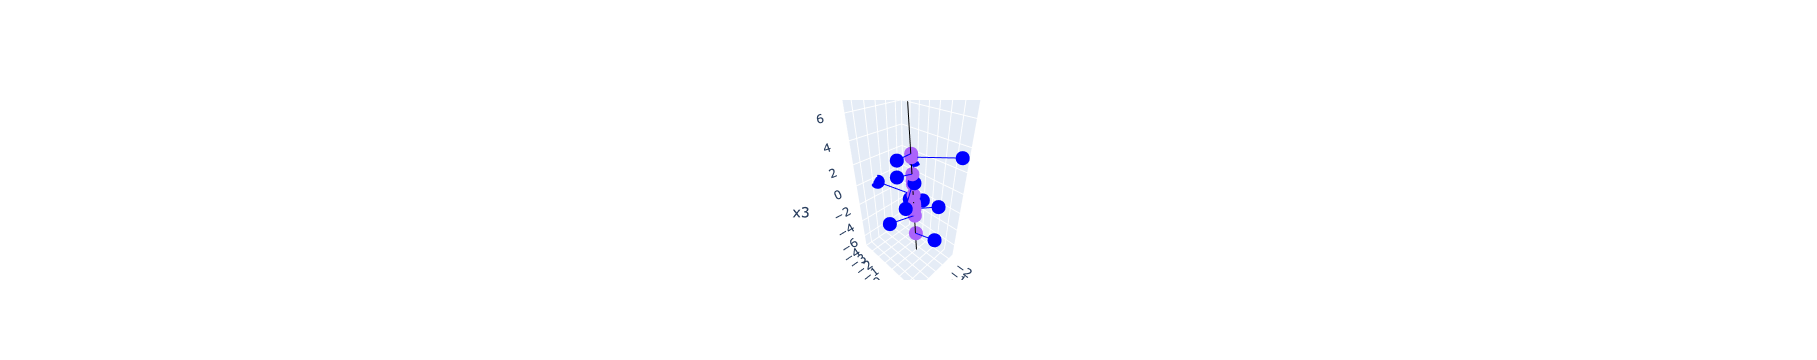

In [6]:
pca = PCA(n_components=1)
pca.fit(X)
plot_d3_k1(X, pca)

- The line corresponds to the $W$ vector. 
- $Z_i$ are the co-ordinates of the $X_i$ projected onto the line. 
- It gives us projected data in the new 1D coordinate system.
- $X_{hat}$ are reconstructions in the original 3D coordinate system.  

### Orthogonal weight vectors

- In PCA, the weight vectors $W$ are orthogonal to each other. So dot product of these vectors is zero. 
- So it finds a transformation such that the transformed features are statistically uncorrelated. 
- Let's bring back our pizza toy example. 

In [7]:
pizza_df = pd.read_csv("data/pizza.csv")
pizza_df.head()

brand     id   mois   prot    fat   ash  sodium  carb   cal
0  A     14069  27.82  21.43  44.87  5.11  1.77    0.77  4.93
1  A     14053  28.49  21.26  43.89  5.34  1.79    1.02  4.84
2  A     14025  28.35  19.99  45.78  5.08  1.63    0.80  4.95
3  A     14016  30.55  20.15  43.13  4.79  1.61    1.38  4.74
4  A     14005  30.49  21.28  41.65  4.82  1.64    1.76  4.67

In [8]:
X_pizza = pizza_df.drop(columns=["id", "brand"])
y_pizza = pizza_df["brand"]
X_pizza.head()

mois   prot    fat   ash  sodium  carb   cal
0  27.82  21.43  44.87  5.11  1.77    0.77  4.93
1  28.49  21.26  43.89  5.34  1.79    1.02  4.84
2  28.35  19.99  45.78  5.08  1.63    0.80  4.95
3  30.55  20.15  43.13  4.79  1.61    1.38  4.74
4  30.49  21.28  41.65  4.82  1.64    1.76  4.67

In [9]:
X_pizza.shape

(300, 7)

In [10]:
n_components = 4
pipe_pca = make_pipeline(StandardScaler(), PCA(n_components=n_components))
pipe_pca.fit(X_pizza)
W = pipe_pca.named_steps["pca"].components_

In [11]:
for i in range(0, W.shape[0] - 1):
    for j in range(1, W.shape[0]):
        if j != i:
            print(
                "Dot product between component %d and component %d: %0.4f"
                % (i, j, np.dot(W[i], W[j]))
            )

Dot product between component 0 and component 1: 0.0000
Dot product between component 0 and component 2: -0.0000
Dot product between component 0 and component 3: 0.0000
Dot product between component 1 and component 2: -0.0000
Dot product between component 1 and component 3: 0.0000
Dot product between component 2 and component 1: -0.0000
Dot product between component 2 and component 3: 0.0000


### Orthonormal weight vectors

In PCA, the weight vectors in $W$ are orthonormal meaning that their length is 1. 

In [12]:
for i in range(0, W.shape[0]):
    print(f"L2 norm of component {i}: {np.linalg.norm(W[i])}") 

L2 norm of component 0: 0.9999999999999999
L2 norm of component 1: 0.9999999999999998
L2 norm of component 2: 0.9999999999999997
L2 norm of component 3: 1.0


### Parts and part weights 

- In PCA terminology, the weight matrix $W$ is often called **parts** and their corresponding values in $Z$ are called **part weights**.
- We could represent an example as a linear combinations of components. 
- How? 

### PCA reconstruction

- We can get $\hat{X}_{n \times d}$ (reconstructed $X$) by matrix multiplication of $Z_{n \times k}$ and $W_{k \times d}$. 
$$\hat{X}_{n \times d} = Z_{n \times k}W_{k \times d} = \begin{bmatrix}
        z_{11} & \ldots & z_{1k}\\ 
        z_{21} & \ldots & z_{2k}\\ 
        & \vdots &\\        
        z_{i1} & \ldots & z_{ik}\\         
        & \vdots &\\
        z_{n1} & \ldots & z_{nk}
        \end{bmatrix}_{n \times k} \times 
        \begin{bmatrix}
            w_{11} & \ldots & w_{1d}\\ 
            w_{21} & \ldots & w_{2d}\\ 
            & \vdots &\\
            w_{k1} & \ldots & w_{kd}
            \end{bmatrix}_{k \times d}$$
- For instance, you can reconstruct an example $\hat{x_{i}}$ as follows:  

$$\hat{x_{i}} = \begin{bmatrix} z_{i1}w_{11} + z_{i2}w_{21} + \dots + z_{ik}w_{k1} \\ z_{i1}w_{12} + z_{i2}w_{22} + \dots + z_{ik}w_{k2}\\ \vdots\\ z_{i1}w_{1d} + z_{i2}w_{2d} + \dots + z_{ik}w_{kd}\end{bmatrix}_{d \times 1}$$

Rearranging the terms, we can see that $z_{i}$ values tell us how much each principal component to use to create this example. 

- Below, I'm writing the image of this funny cat from your lab as a linear combination of principal components ("parts"). 
- The coefficients in $Z$ tell us how much of each principal component to use to create this image.  
- In this image, components 0, 1, 3, 13 seem to be playing an important role.   

![](img/PCA-batcat-rep.png)

<br><br><br><br>

## Choosing the number of components $k$

- Similar to K-Means there is no definitive answer.
- But we can use some strategies to help us out:
    - Look at the total explained variance by $k$ components.
    - Look at the reconstructions with $k$ components. 

- In PCA, principal components in $W$ are ordered by how much variance of the data they cover. 
- We can look at cumulative variance ratio (`explained_variance_ratio_` in `sklearn`) to select how many components we want. 
- When the data is human interpretable (e.g., images), you can also look at the reconstructions to help make this decision. 

- When we train a PCA model, it returns the amount of variance explained by each of the components. 
- In `sklearn`, we can access this using the `explained_variance_` attribute of the pca object.  
- And we can access the percentage of variance explained by each of the selected components with `explained_variance_ratio_` 
- Let's explore this on our toy pizza example. 

In [13]:
n_components = 2
pipe_pca = make_pipeline(StandardScaler(), PCA(n_components=n_components))
pipe_pca.fit(X_pizza)
W = pipe_pca.named_steps["pca"].components_

In [14]:
pipe_pca.named_steps["pca"].explained_variance_

array([4.18573434, 2.29811778])

In [15]:
pipe_pca.named_steps["pca"].explained_variance_ratio_

array([0.59596884, 0.3272082 ])

In [16]:
pipe_pca.named_steps["pca"].explained_variance_ratio_.sum()

0.9231770406002875

We are capturing 92.31% of the information using only two of these newly created features!!  

Let's look at how much "information" we can capture with different number of components. 

In [17]:
n_components = 7
pipe_pca = make_pipeline(StandardScaler(), PCA(n_components=n_components))
pipe_pca.fit(X_pizza)
W = pipe_pca.named_steps["pca"].components_

In [18]:
df = pd.DataFrame(
    data=np.cumsum(pipe_pca["pca"].explained_variance_ratio_),
    columns=["variance_explained (%)"],
    index=range(1, n_components + 1),
)
df.index.name = "n_components"

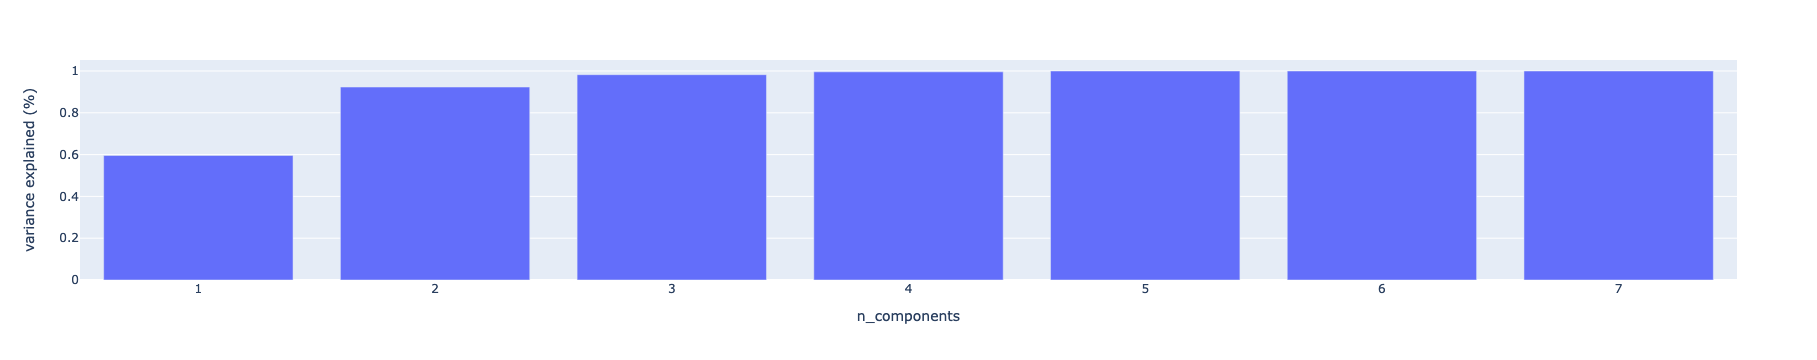

In [19]:
simple_bar_plot(
    x=df.index.tolist(),
    y=df["variance_explained (%)"],
    x_title="n_components",
    y_title="variance explained (%)",
)

In [20]:
pipe_pca.named_steps["pca"].explained_variance_

array([4.18573434e+00, 2.29811778e+00, 4.15948838e-01, 9.54925358e-02,
       2.77695834e-02, 3.38738483e-04, 9.55061572e-06])

Here is the percentage variance explained by the model. 

In [21]:
pipe_pca.named_steps["pca"].explained_variance_ratio_.sum()

1.0

The sum of explained variance ratio covered by all components should be close to 1. 

Let's explore this on a larger dataset. 

In [22]:
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["image.cmap"] = "gray"

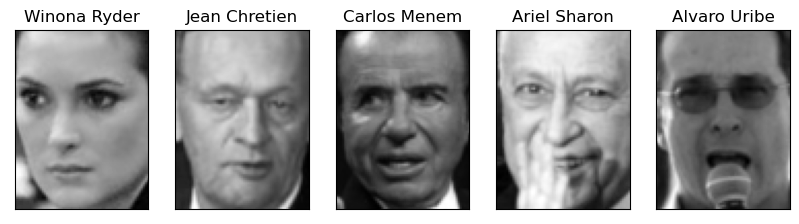

In [23]:
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

fig, axes = plt.subplots(1, 5, figsize=(10, 8), subplot_kw={"xticks": (), "yticks": ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])
plt.show()

In [24]:
image_shape = (87, 65)

In [25]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:20]] = 1

X_people = people.data[mask]
y_people = people.target[mask]
X_people = X_people / 255.0

/var/folders/ky/533nd9l512l5cmmk_kzmzj9m0000gp/T/ipykernel_3140/2286816902.py:1: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [26]:
X_people.shape

(1240, 5655)

In [27]:
n_components = 500
pca = PCA(n_components=n_components, whiten=True, random_state=0)
pca.fit(X_people)

PCA(n_components=500, random_state=0, whiten=True)

In [28]:
df = pd.DataFrame(
    data=np.cumsum(pca.explained_variance_ratio_),
    columns=["variance_explained (%)"],
    index=range(1, n_components + 1),
)
df.index.name = "n_components"

In [29]:
df

variance_explained (%)
n_components                        
1             0.225923              
2             0.337310              
3             0.410737              
4             0.476003              
5             0.510355              
...                ...              
496           0.991739              
497           0.991777              
498           0.991814              
499           0.991851              
500           0.991888              

[500 rows x 1 columns]

- It doesn't make sense to plot a bar chart here, as we have so many components. 
- How about plotting number od components vs. explained variance? 

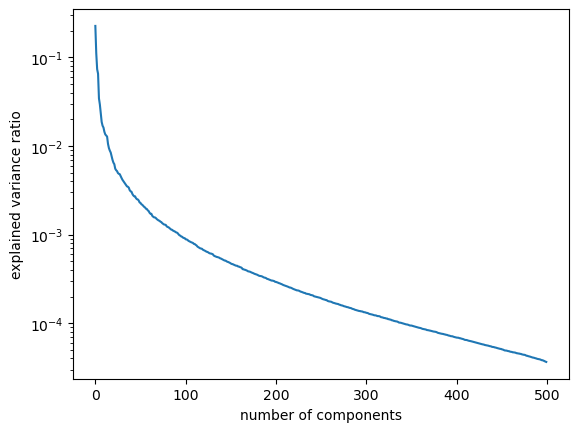

In [30]:
plt.semilogy(pca.explained_variance_ratio_)
plt.xlabel("number of components")
plt.ylabel("explained variance ratio");

- A more useful plot is number of components vs. cumulative explained variance ratio. 

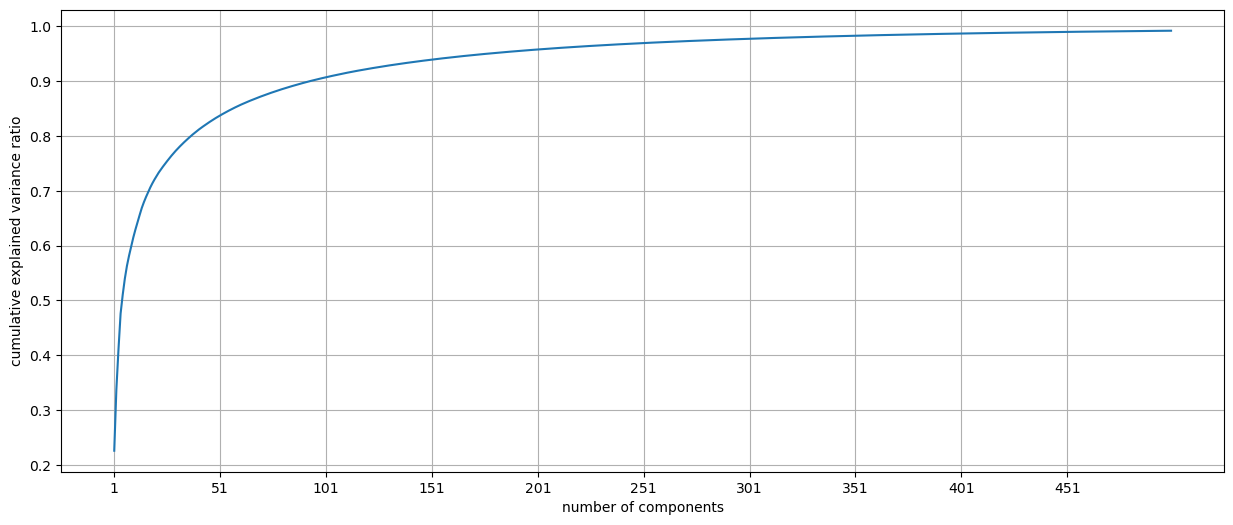

In [31]:
plt.figure(figsize=(15, 6))
plt.plot(range(1, 501), np.cumsum(pca.explained_variance_ratio_))
plt.xticks(range(1, 501, 50))
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance ratio")
plt.grid();

- Seems like we are capturing ~90% variance with only ~100 components! Remember that our dimensionality in the original dataset is 5655.  
- How do we choose the best value for the number of components? This will be application dependent. In general, I would go with a value which covers > 90% variance in the data.   

<br><br><br><br>

### PCA and multicollinearity 

#### Discussion questions 

- How do you think multicollinearity would affect PCA.
- Would PCA be affected in case of multi-collinearity?

- We will get $d$ orthogonal vectors.
- But the variance explained in the last components would be zero. 

### PCA and outliers
- PCA may or may not maintain outliers after applying transformation. 
- In the anomaly detection application, our assumption is that PCA is not able to maintain outliers and hence the reconstruction error for them would be higher compared to normal examples. 

> Robust PCA is more appropriate for anomaly detection task. We're not using it in lab because it's not implemented in `sklearn`. That said there are some external packages available. For example see [this implementation of robust PCA](https://github.com/dganguli/robust-pca). Also, `sklearn` might have it sometime soon. See [here](https://github.com/scikit-learn/scikit-learn/issues/5851). 


### K-Means and PCA 

- You can think of PCA as generalization of K-Means. 
- In case of K-Means we learn a set of cluster centers and memorize these $K$ centers. 
- We represent the dataset in terms of those centers. 
- $W$ in K-Means has $K$ $d$-dimensional cluster centers. 
- $Z_i$ tells us which center the point belongs to. Each row of $Z$ has one element equal to one and the other are zero, indicating the cluster of that row.

In [32]:
X, y = make_blobs(n_samples=10, centers=3, n_features=2, random_state=10)
pd.DataFrame(X, columns=["feat1", "feat2"])

feat1      feat2
0  5.691924 -9.476412 
1  1.707899  6.004352 
2  0.236210 -3.119100 
3  2.901595  5.421215 
4  5.859439 -8.381924 
5  6.047749 -10.305047
6 -2.007588 -7.247439 
7  1.454677 -6.583872 
8  1.536362  5.111215 
9  5.430704 -9.759561

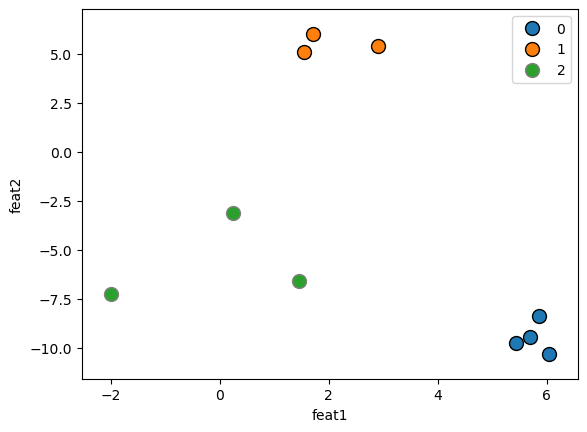

In [33]:
from sklearn.cluster import KMeans
mglearn.discrete_scatter(X[:, 0], X[:, 1], y, markers="o")
plt.xlabel("feat1")
plt.ylabel("feat2")

plt.legend();

In [34]:
n_clusters = 3
km = KMeans(n_clusters=n_clusters)
km.fit(X)
cluster_labels = km.labels_

In [35]:
Z_km = np.zeros((len(X), n_clusters), dtype="int32")
for i in range(len(X)):
    Z_km[i, cluster_labels[i]] = 1

col_names = ["center" + str(i) for i in range(n_clusters)]
pd.DataFrame(Z_km, columns=col_names)

center0  center1  center2
0  0        1        0      
1  1        0        0      
2  0        0        1      
3  1        0        0      
4  0        1        0      
5  0        1        0      
6  0        0        1      
7  0        0        1      
8  1        0        0      
9  0        1        0

In [36]:
W_km = km.cluster_centers_
pd.DataFrame(W_km, columns=["feat1", "feat2"])

feat1     feat2
0  2.048619  5.512261
1  5.757454 -9.480736
2 -0.105567 -5.650137

- So we decompose $X$ as 
     $$X_{(n\times d)} \approx Z_{(n\times k)}W_{(k\times d)}$$
     
- You can think of reconstruction of each point as $\hat{X_i} = Z_iW$
- The reconstruction error would be high because we are capturing all data points in terms of just K cluster centers. 
- $Z$ in not continuous.

- PCA is a generalization that allows continuous values of $Z_i$s. 
- Does it make sense to `fit` a PCA model here with `n_components=3`? 

<br><br><br><br>

## ❓❓ Questions for you
iClicker cloud join link: https://join.iclicker.com/MA16T

### Select all of the following statements which are **True** (iClicker)

- (A) A bigger value (in magnitude) of $Z_{i1}$ in the transformed data $Z$ means that component 1 does not play a big role in the decomposition of example $X_i$. 
- (B) Columns in $Z$ tell us about the amount of contribution of that principal component in the corresponding examples. 
- (C) In K-Means, each example is expressed with only one component or part whereas in PCA, each example is expressed with a linear combination of all components.   
- (D) If you have two collinear features in the data, PCA would only be able to find $d-1$ components because $d-1$ components would capture all the variance. 
- (E) In PCA, the components are statistically uncorrelated. 

<br><br><br><br>

``{admonition} Exercise 4.1 

- (A) A bigger value (in magnitude) of $Z_{i1}$ in the transformed data $Z$ means that component 1 does not play a big role in the decomposition of example $X_i$. 
- (B) Columns in $Z$ tell us about the amount of contribution of that principal component in the corresponding examples. 
- (C) In K-Means, each example is expressed with only one component or part whereas in PCA, each example is expressed with a linear combination of all components.   
- (D) If you have two collinear features in the data, PCA would only be able to find $d-1$ components because $d-1$ components would capture all the variance. 
- (E) In PCA, the components are statistically uncorrelated. 

```

```{admonition} Exercise 3.1: V's Solutions!
:class: tip, dropdown

- (A) False
- (B) True
- (C) True
- (D) False
- (E) True
```

### Questions for discussion 

- What are similarities and differences between PCA and K-Means? 
- What are the advantages and disadvantages of dimensionality reduction using feature selection methods such as forward selection or RFE vs. PCA?  

## Break 

![](img/eva-coffee.png)

<br><br><br><br>

## Varieties/extensions of PCA

### PCA extensions

There are a number of PCA generalizations and extensions. Here are some examples. 

- [TuncatedSVD or Latent Semantic Analysis (LSA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)
- [Non negative matrix factorization (NMF)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)
- [Sparse PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html) or [Mini-batch sparse PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.MiniBatchSparsePCA.html)
- [KernelPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html)
- [IncrementalPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html)
- Robust PCA (not implemented in sklearn yet)
- ...

In the next sections we'll see examples of `LSA` and NMF. 

### Latent Semantic Analysis (LSA)

- Similar to PCA but does not center the data before calling SVD. 
- Useful for extracting semantically meaningful components of high dimensional sparse data.
- We can't easily use PCA in such cases because we can't subtract mean; if we do, it would force dense representation of the data and we won't even be able to store it. 

- Useful in the context of text data because BOW representation of text data is usually sparse and high dimensional. 
- This is also referred to as Latent Semantic Indexing (LSI) in the context of information retrieval.
- In `scikit-learn` the way to do this is using [`TruncatedSVD`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).  
    - Contrary to PCA, this algorithm does not center the data before calling `SVD`. 
    - So it's suitable for sparse, high-dimensional matrices (e.g., features extracted by `CountVectorizer`). 

- You can think of LSA as a tool for extracting semantic features or "topics" from a given set of documents. 
- It creates a dense representation of documents. 

$$X_{n \times d} \approx ZW$$


- Let's get an intuition for LSA with a toy example. 

In [39]:
import wikipedia
from nltk.tokenize import sent_tokenize, word_tokenize

queries = [
    "Raspberry",
    "pineapple juice",
    "mango fruit",
    "ice hockey",
    "ice skating",
    "hockey sport",
]

wiki_dict = {"wiki query": [], "text": [], "n_words": []}
for i in range(len(queries)):
    sent = sent_tokenize(wikipedia.page(queries[i]).content)[0]
    wiki_dict["text"].append(sent)
    wiki_dict["n_words"].append(len(word_tokenize(sent)))
    wiki_dict["wiki query"].append(queries[i])

# extra_sent = "Mango and pineapple are tropical. It's fun to eat fresh fruit while wacthing ice hockey."    
mixed_sent = "Margot likes to eat mango while watching ice skating."
wiki_dict["text"].append(mixed_sent)
wiki_dict["n_words"].append(len(word_tokenize(mixed_sent)))
wiki_dict["wiki query"].append('mixed')

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

wiki query  \
0  Raspberry         
1  pineapple juice   
2  mango fruit       
3  ice hockey        
4  ice skating       
5  hockey sport      
6  mixed             

                                                                                                                                                                                                     text  \
0  The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.                                                   
1  Pineapple juice is a liquid made from pressing the natural liquid from the pulp of the pineapple (a fruit from a tropical plant).                                                                        
2  A mango is an edible stone fruit produced by the tropical tree Mangifera indica which is believed to have originated from the region between northwestern Myanmar, Bangladesh, and northeastern India.   
3  Ice hockey is a contact winter team sport played on ice skates, usually on an ice skating rink with lines and markings specific to the sport.                                                            
4  Ice skating is the self-propulsion and gliding of a person across an ice surface, using metal-bladed ice skates.                                                                                         
5  Hockey is a term used to denote various types of both summer and winter team sports which originated on either an outdoor field, sheet of ice, or dry floor such as in a gymnasium.                      
6  Margot likes to eat mango while watching ice skating.                                                                                                                                                    

   n_words  
0  30       
1  26       
2  33       
3  28       
4  20       
5  37       
6  10

Let's get BOW representation of the documents. 

In [40]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words="english")
bow = cv.fit_transform(wiki_df["text"]).toarray()
bow_df = pd.DataFrame(bow, columns=cv.get_feature_names_out(), index=wiki_df["text"])
bow_df

bangladesh  \
text                                                                                                                                                                                                                 
The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.                                                  0            
Pineapple juice is a liquid made from pressing the natural liquid from the pulp of the pineapple (a fruit from a tropical plant).                                                                       0            
A mango is an edible stone fruit produced by the tropical tree Mangifera indica which is believed to have originated from the region between northwestern Myanmar, Bangladesh, and northeastern India.  1            
Ice hockey is a contact winter team sport played on ice skates, usually on an ice skating rink with lines and markings specific to the sport.                                                           0            
Ice skating is the self-propulsion and gliding of a person across an ice surface, using metal-bladed ice skates.                                                                                        0            
Hockey is a term used to denote various types of both summer and winter team sports which originated on either an outdoor field, sheet of ice, or dry floor such as in a gymnasium.                     0            
Margot likes to eat mango while watching ice skating.                                                                                                                                                   0            

                                                                                                                                                                                                        believed  \
text                                                                                                                                                                                                               
The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.                                                  0          
Pineapple juice is a liquid made from pressing the natural liquid from the pulp of the pineapple (a fruit from a tropical plant).                                                                       0          
A mango is an edible stone fruit produced by the tropical tree Mangifera indica which is believed to have originated from the region between northwestern Myanmar, Bangladesh, and northeastern India.  1          
Ice hockey is a contact winter team sport played on ice skates, usually on an ice skating rink with lines and markings specific to the sport.                                                           0          
Ice skating is the self-propulsion and gliding of a person across an ice surface, using metal-bladed ice skates.                                                                                        0          
Hockey is a term used to denote various types of both summer and winter team sports which originated on either an outdoor field, sheet of ice, or dry floor such as in a gymnasium.                     0          
Margot likes to eat mango while watching ice skating.                                                                                                                                                   0          

                                                                                                                                                                                                        bladed  \
text                                                                                                                                                      

- Each document is represented with 68 features, i.e., words. 
- Probably there is a set of features related to sports (e.g., _team, sport, ice, hockey, outdoor, played, skating_) and a set of features related to fruit (e.g., _fruit, juice, mango, tree, tropical_)? 

- Can we extract these **latent features**, which are there in the data but haven't manifested yet? 

In [42]:
lsa_pipe = make_pipeline(
    CountVectorizer(stop_words="english"), TruncatedSVD(n_components=2)
)

lsa_transformed = lsa_pipe.fit_transform(wiki_df["text"]);

In [43]:
pd.DataFrame(
    np.round(lsa_transformed, 4),
    columns=["latent topic 1 ", "latent topic 2"],
    index=wiki_df["text"],
)

latent topic 1   \
text                                                                                                                                                                                                                      
The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.                                                  0.0142            
Pineapple juice is a liquid made from pressing the natural liquid from the pulp of the pineapple (a fruit from a tropical plant).                                                                       0.0160            
A mango is an edible stone fruit produced by the tropical tree Mangifera indica which is believed to have originated from the region between northwestern Myanmar, Bangladesh, and northeastern India.  0.1614            
Ice hockey is a contact winter team sport played on ice skates, usually on an ice skating rink with lines and markings specific to the sport.                                                           4.4995            
Ice skating is the self-propulsion and gliding of a person across an ice surface, using metal-bladed ice skates.                                                                                        3.3551            
Hockey is a term used to denote various types of both summer and winter team sports which originated on either an outdoor field, sheet of ice, or dry floor such as in a gymnasium.                     2.0283            
Margot likes to eat mango while watching ice skating.                                                                                                                                                   1.1238            

                                                                                                                                                                                                        latent topic 2  
text                                                                                                                                                                                                                    
The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.                                                  1.5085          
Pineapple juice is a liquid made from pressing the natural liquid from the pulp of the pineapple (a fruit from a tropical plant).                                                                       2.2111          
A mango is an edible stone fruit produced by the tropical tree Mangifera indica which is believed to have originated from the region between northwestern Myanmar, Bangladesh, and northeastern India.  3.4017          
Ice hockey is a contact winter team sport played on ice skates, usually on an ice skating rink with lines and markings specific to the sport.                                                          -0.2619          
Ice skating is the self-propulsion and gliding of a person across an ice surface, using metal-bladed ice skates.                                                                                       -0.3132          
Hockey is a term used to denote various types of both summer and winter team sports which originated on either an outdoor field, sheet of ice, or dry floor such as in a gymnasium.                     0.7193          
Margot likes to eat mango while watching ice skating.                                                                                                                                                   0.1463

- Latent topic 2 seems to be dominant in the fruit-related documents. 
- Latent topic 1 seems to be dominant in sports-related documents. 

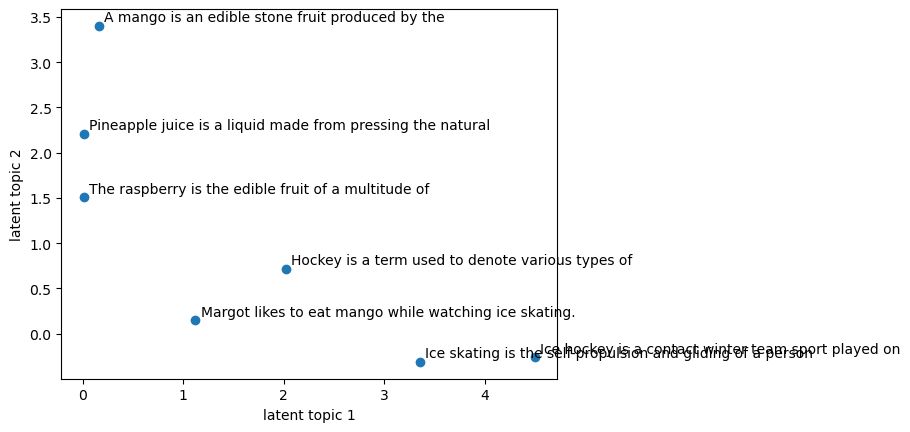

In [44]:
plt.scatter(lsa_transformed[:, 0], lsa_transformed[:, 1])
plt.xlabel("latent topic 1")
plt.ylabel("latent topic 2")
x = lsa_transformed[:, 0]
y = lsa_transformed[:, 1]
for i, txt in enumerate(wiki_df["text"]):
    plt.annotate(" ".join(txt.split()[:10]), (x[i] + 0.05, y[i] + 0.05))

Let's examine the components learned by LSA. 
- How much variance is covered by these two components? 

In [45]:
lsa_pipe.named_steps["truncatedsvd"].explained_variance_ratio_.sum()

0.35445689526600116

Good to know! 

- Our features are word counts. 
- Which features have higher weights in latent topic 1 vs. latent topic 2? 

### Most important words for latent topic 1

In [46]:
vocab = lsa_pipe.named_steps["countvectorizer"].get_feature_names_out()

In [47]:
pd.DataFrame(
    np.absolute(lsa_pipe.named_steps["truncatedsvd"].components_.T),
    columns=["latent topic 1", "latent topic 2"],
    index=vocab,
).sort_values("latent topic 1", ascending=False)

latent topic 1  latent topic 2
ice         0.723894        0.044223      
sport       0.243839        0.026947      
skating     0.243278        0.022056      
skates      0.212828        0.029582      
hockey      0.176879        0.023524      
...              ...             ...      
rose        0.000386        0.077593      
raspberry   0.000386        0.077593      
multitude   0.000386        0.077593      
idaeobatus  0.000386        0.077593      
genus       0.000386        0.077593      

[72 rows x 2 columns]

### Most important words for latent topic 2

In [48]:
pd.DataFrame(
    np.absolute(lsa_pipe.named_steps["truncatedsvd"].components_.T),
    columns=["latent topic 1", "latent topic 2"],
    index=vocab,
).sort_values("latent topic 2", ascending=False)

latent topic 1  latent topic 2
fruit      0.005194        0.366295      
tropical   0.004808        0.288702      
edible     0.004759        0.252563      
pineapple  0.000869        0.227463      
liquid     0.000869        0.227463      
...             ...             ...      
contact    0.121919        0.013474      
margot     0.030450        0.007526      
likes      0.030450        0.007526      
eat        0.030450        0.007526      
watching   0.030450        0.007526      

[72 rows x 2 columns]

You can print these words in a nice format using `mglearn.tools.print_topics`. 

In [49]:
sorting = np.argsort(lsa_pipe.named_steps["truncatedsvd"].components_, axis=1)[:, ::-1]

feature_names = np.array(
    lsa_pipe.named_steps["countvectorizer"].get_feature_names_out()
)
mglearn.tools.print_topics(
    topics=[0, 1], feature_names=feature_names, sorting=sorting, n_words=20
)

topic 0       topic 1       
--------      --------      
ice           fruit         
sport         tropical      
skating       edible        
skates        pineapple     
winter        liquid        
team          originated    
hockey        plant         
specific      mango         
contact       bangladesh    
rink          believed      
markings      indica        
usually       northeastern  
lines         produced      
played        myanmar       
propulsion    region        
using         mangifera     
gliding       northwestern  
surface       india         
bladed        stone         
self          tree          




This makes sense!! 
- LSA has learned two useful "concepts" or latent features from 62 word count features: **sports** and **fruit**. 
- A nice thing is that this is completely unsupervised. 
- Instead of using BOW representation, we can create LSA representation of documents and pass it to supervised models.  

<br><br><br><br>

Let's try it out on a larger dataset.  

In [50]:
df = pd.read_csv("data/cleaned_hm.csv", index_col=0)
sample_df = df.dropna()
sample_df.head()

wid reflection_period  \
hmid                            
27676  206   24h                
27678  45    24h                
27697  498   24h                
27705  5732  24h                
27715  2272  24h                

                                                                                                                              original_hm  \
hmid                                                                                                                                        
27676  We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.   
27678  I meditated last night.                                                                                                              
27697  My grandmother start to walk from the bed after a long time.                                                                         
27705  I picked my daughter up from the airport and we have a fun and good conversation on the way home.                                    
27715  when i received flowers from my best friend                                                                                          

                                                                                                                               cleaned_hm  \
hmid                                                                                                                                        
27676  We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.   
27678  I meditated last night.                                                                                                              
27697  My grandmother start to walk from the bed after a long time.                                                                         
27705  I picked my daughter up from the airport and we have a fun and good conversation on the way home.                                    
27715  when i received flowers from my best friend                                                                                          

       modified  num_sentence ground_truth_category predicted_category  
hmid                                                                    
27676  True      2             bonding               bonding            
27678  True      1             leisure               leisure            
27697  True      1             affection             affection          
27705  True      1             bonding               affection          
27715  True      1             bonding               bonding

A common transformation steps before calling LSA for text data is applying [`TfidfTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html). 

- TF $\rightarrow$ term frequency 
- TF-IDF $\rightarrow$ term frequency times inverse document frequency

In [51]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MaxAbsScaler

n_components = 10
lsa_moments_pipe = make_pipeline(
    CountVectorizer(stop_words="english", ngram_range=(1, 1)),
    TfidfTransformer(),
    TruncatedSVD(n_components=n_components, n_iter=100, random_state=42),
)
lsa = lsa_moments_pipe.fit_transform(sample_df["cleaned_hm"]);

In [52]:
sorting = np.argsort(lsa_moments_pipe.named_steps["truncatedsvd"].components_, axis=1)[:, ::-1]
feature_names = np.array(
    lsa_moments_pipe.named_steps["countvectorizer"].get_feature_names_out()
)
mglearn.tools.print_topics(
    topics=np.arange(0, n_components),
    feature_names=feature_names,
    sorting=sorting,
    n_words=20,
)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       
--------      --------      --------      --------      --------      --------      
went          movie         new           friend        new           dinner        
movie         went          got           new           bought        went          
happy         temple        job           party         happy         temple        
got           shopping      bought        best          car           friends       
time          wend          movie         birthday      dinner        family        
friend        mall          car           bought        family        got           
new           theater       work          got           wife          shopping      
friends       college       laptop        marriage      moment        wife          
family        center        promotion     car           friends       college       
work          browsing      finally       job           house    

- I don't see any coherent themes in these topics. 
- In 575, we'll revisit topic modeling with a Bayesian method called Latent Dirichlet Allocation (LDA). 

How much variance is covered by these components?

In [53]:
lsa_moments_pipe.named_steps["truncatedsvd"].explained_variance_ratio_

array([0.00879839, 0.00938886, 0.00818208, 0.00740802, 0.00662133,
       0.0058987 , 0.0055443 , 0.0054681 , 0.0052172 , 0.00496836])

- Truncated SVD does not find the directions of greatest variance when the data are not pre-centered. See [here](https://github.com/scikit-learn/scikit-learn/issues/3047). 

- And unlike PCA the explained variance does not decrease monotonically.  

Let's compare classification performance using countvectorizer features vs. LSA features. 

In [54]:
from sklearn.model_selection import cross_validate, train_test_split

train_df, test_df = train_test_split(sample_df, test_size=0.2, random_state=123)
X_train, y_train = train_df["cleaned_hm"], train_df["ground_truth_category"]
X_test, y_test = test_df["cleaned_hm"], test_df["ground_truth_category"]

In [55]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(
    CountVectorizer(stop_words="english"),
    TfidfTransformer(),
    LogisticRegression(max_iter=1000),
)

pipe.named_steps["countvectorizer"].fit(X_train)
X_train_transformed = pipe.named_steps["countvectorizer"].transform(X_train)
print("Data matrix shape:", X_train_transformed.shape)
pipe.fit(X_train, y_train)
print("Train accuracy {:.2f}".format(pipe.score(X_train, y_train)))
print("Test accuracy {:.2f}".format(pipe.score(X_test, y_test)))

Data matrix shape: (11300, 8592)
Train accuracy 0.89
Test accuracy 0.81


In [56]:
n_components = 2000
lsa_pipe = make_pipeline(
    CountVectorizer(stop_words="english"),
    TfidfTransformer(),
    TruncatedSVD(n_components=n_components, n_iter=100, random_state=42),
    LogisticRegression(max_iter=1000),
)

In [ ]:
# Commenting because this takes a while
# lsa_pipe.fit(X_train, y_train)
# print("Train accuracy {:.2f}".format(lsa_pipe.score(X_train, y_train)))
# print("Test accuracy {:.2f}".format(lsa_pipe.score(X_test, y_test)))

- Similar performance with less overfitting with a lot less features (8592 features vs. 2000 features). 
- But it took a lot longer to extract these components. 

Another common way to preprocess counts data is using [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html), which scales each feature with its maximum absolute value.  

<br><br>

### [Non-negative matrix factorization (NMF)](http://www.cs.columbia.edu/~blei/fogm/2018F/materials/LeeSeung1999.pdf)

- Published in Nature. 

### NMF intuition 
- Another unsupervised learning algorithm to extract useful features. 
- Non-negative matrix factorization (NMF) uses a similar decomposition but with different constraints imposed on $Z$ and $W$. 
$$X_{(n\times d)} \approx Z_{(n\times k)}W_{(k\times d)}$$   
- Unlike PCA, the components are neither orthogonal to each other nor are they sorted by the variance explained by them. 
- The constraint in NMF is that both $Z$ and $W$ will be allowed to contain only non-negative values. 
- This means that it can only be applied to data where each feature is non-negative, as non-negative sum of non-negative components cannot become negative.

- The NMF "components" will only be adding things. 
- Once something is added it cannot be removed because we cannot subtract anything. 
- For example, in PCA you can have something like 
    - $X_i = 14W_0 - 9W_2$, a cancellation effect from subtraction. 
- In NMF, once you added $14W_0$ it cannot be cancelled out. 
- This usually leads to more interpretable models, as there are no cancellation effects due to different signs. 

### PCA Representation 
![](img/PCA-batcat-rep.png)

### NMF representation

- Everything is positive!
- No cancellation effects. 
![](img/nmf-batcat-ex.png)

- Helpful in scenarios where data is created with several independent sources. For example:  
    - audio track of multiple people speaking
    - music with many instruments
- The goal is to identify the original components that make up the combined data. 
- Relates to the notion of combining parts to create a whole. 

/Users/kvarada/opt/miniconda3/envs/563/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/Users/kvarada/opt/miniconda3/envs/563/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.

/Users/kvarada/opt/miniconda3/envs/563/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/Users/kvarada/opt/miniconda3/envs/563/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



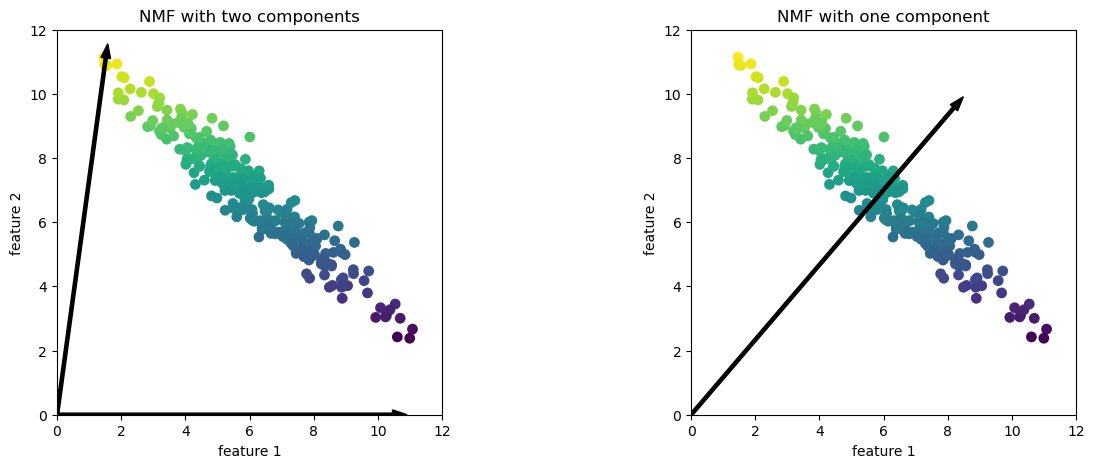

In [57]:
mglearn.plots.plot_nmf_illustration();

- In this case, if `n_components=2`, the components point towards the extremes of the data. 
- If we only have 1 component, according to NMF, point toward the mean best explains the data. 

### Effect of `n_components` on PCA vs. NMF

- PCA is a **global algorithm** in the sense that the first principal component always points toward the direction of maximum variance and the second principal component toward the direction of second maximum variance and so on. 
- Changing the value for the number of components does not change this. 
- In contrast, in NMF, with different number of components we get entirely different set of components. 
- Components in NMF are also not ordered in any specific way and all components play an equal part.

Let's go back to our people faces dataset. 

In [58]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=15, init="random", random_state=0, max_iter=5000)
nmf.fit(X_people)
X_people_nmf = nmf.transform(X_people)

NMF is slower than PCA.  

Let's try to interpret the components given by NMF. 

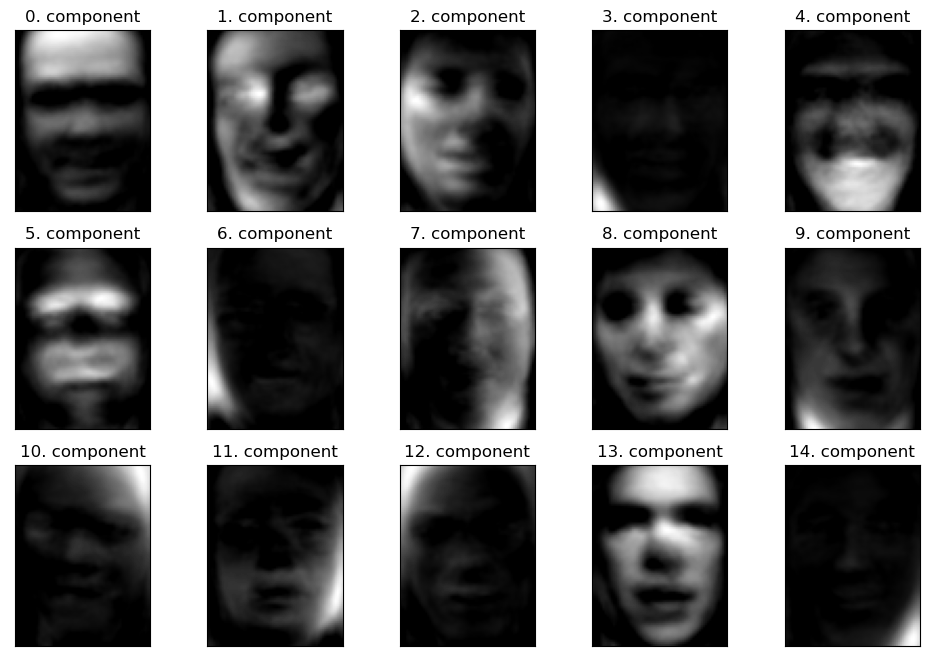

In [59]:
fig, axes = plt.subplots(3, 5, figsize=(12, 8), subplot_kw={"xticks": (), "yticks": ()})

for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("{}. component".format(i))

In [60]:
def plot_strong_comp_images(compn=1):
    inds = np.argsort(X_people_nmf[:, compn])[::-1]
    fig, axes = plt.subplots(
        2, 5, figsize=(8, 3), subplot_kw={"xticks": (), "yticks": ()}
    )
    fig.suptitle("Large component %d" % (compn))
    for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
        if i == 0: 
            ax.imshow(nmf.components_[compn].reshape(image_shape))
        else:     
            ax.imshow(X_people[ind].reshape(image_shape))

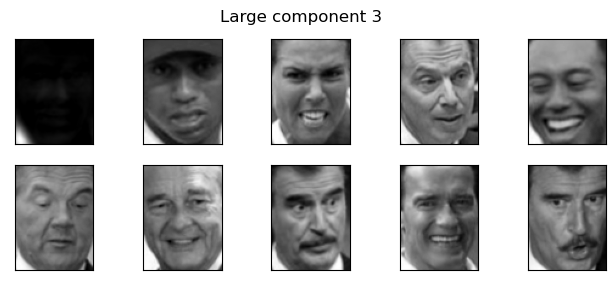

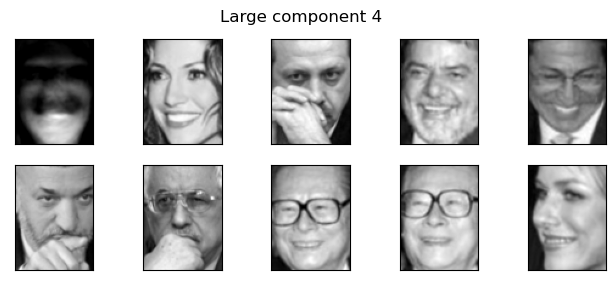

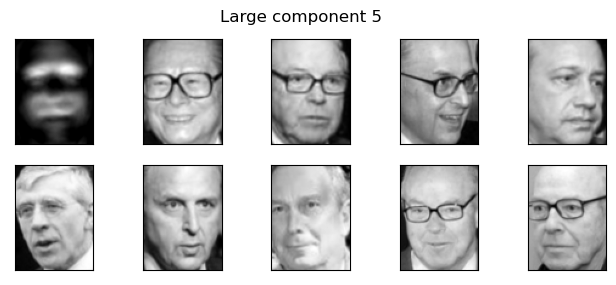

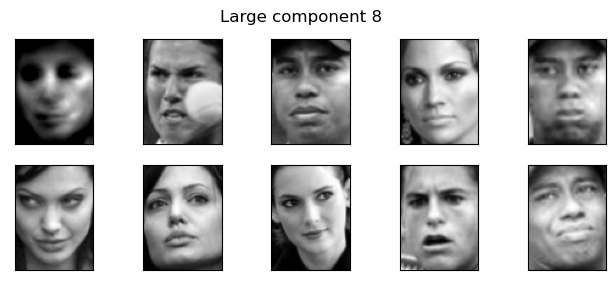

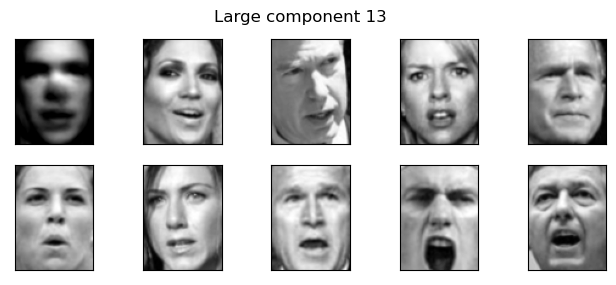

In [61]:
interesting_comps = [3, 4, 5, 8, 13]
for compn in interesting_comps:
    plot_strong_comp_images(compn)

## Take-away points 

- For NMF everything is non-negative: the data, the components, and the transformed points. 
- Terms cannot cancel each other out which makes it more interpretable. 
- Unlike PCA, changing the number of components actually changes the directions of the other components. 


<br><br><br><br>

## (Optional) Autoencoders

### Autoencoders 

<img src="img/autoencoder_digits.jpg" alt="" height="600" width="600"> 

[Source](https://blog.keras.io/building-autoencoders-in-keras.html)

- Unsupervised learning technique for representation learning and dimensionality reduction.  
- It's a neural network architecture. 
- The idea is to create a "bottleneck" in the network so that the network is forced to learn compressed representation of the data. 


### Autoencoder architecture

<img src="img/autoencoder_wiki.png" alt="" height="400" width="400"> 

[Source](https://en.wikipedia.org/wiki/Autoencoder)

- The input layer is a vector representation of a data point. 
- It has two phases: encoding and decoding. 
- Encoding: The first layer transformed to a hidden layer. 
- Decoding: The last layer converts the lower dimensional representation back to the original dimensionality.

### What does it learn? 

- An autoencoder aims to minimize the distance of this reconstructed vector and the original vector. 
- And during this process, it creates good lower dimensional representations of the data. 


- Recall this picture of an autoencoder from 572. 
- Here we have more than one hidden layers. 
<img src="img/autoencoder.png" alt="" height="500" width="500"> 

### Non-linearity in autoencoders

- PCA is a linear dimensionality reduction technique. 
- Autoencoders are non-linear because of non-linear activation functions. 
- In fact, if we construct the network without non-linear activation function at each layer, we would observe similar dimensionality reduction as that of PCA. 

<br><br><br><br>

## ❓❓ Questions for you
iClicker cloud join link: https://join.iclicker.com/MA16T

### Select all of the following statements which are **True** (iClicker)

- (A) Suppose you are working with a dataset with 10 dimensions. You train `PCA` with `n_components=4` first. Then you train it with `n_components=1`. The first component is most likely to be the same in both cases. 
- (B) Suppose you are working with a dataset with 10 dimensions. You train `NMF` with `n_components=4` first. Now if you train `NMF` with `n_components=1`. The first component is most likely to be the same in both cases.
- (C) Unlike bag-of-words representation, `TruncatedSVD` (LSA) gives a short and dense representation of documents. 
- (D) In LSA, the weight vectors in $W$ can be thought of as topics extracted from a set of documents. 
- (E) In LSA, the coefficients from the transformed data tell us the proportion of each topic in a given document. 

<br><br><br><br>

``{admonition} Exercise 4.2 

- (A) Suppose you are working with a dataset with 10 dimensions. You train `PCA` with `n_components=4` first. Then you train it with `n_components=1`. The first component is most likely to be the same in both cases. 
- (B) Suppose you are working with a dataset with 10 dimensions. You train `NMF` with `n_components=4` first. Now if you train `NMF` with `n_components=1`. The first component is most likely to be the same in both cases.
- (C) Unlike bag-of-words representation, `TruncatedSVD` (LSA) gives a short and dense representation of documents. 
- (D) In LSA, the weight vectors in $W$ can be thought of as topics extracted from a set of documents. 
- (E) In LSA, the coefficients from the transformed data tell us the proportion of each topic in a given document. 

```

```{admonition} Exercise 3.1: V's Solutions!
:class: tip, dropdown

- (A) True
- (B) False
- (C) True
- (D) True
- (E) True
```

<br><br><br><br>

## Final comments, summary, reflection

### Take-home message

- PCA can be thought of as generalization of K-Means.
- In general, linear dimensionality reduction techniques represent each example as a linear combinations of components in $W$. 
- There are no definitive methods to decide the number of components. Two things which can help us out are 
    - looking at the explained variance in case of PCA 
    - looking at reconstructions 
- There are many variants and extensions of PCA.        
- `TruncatedSVD` or LSA is appropriate in the context of sparse text data, as it doesn't center the data. 
- In NMF everything is non-negative. 
- It is appropriate when you have non-negative data and interpretation is important for you.
- Also, it's useful when data is created as the addition of several independent sources (e.g., music with multiple sources) because NMF can identify the original components that make up the combined data. 

### Reflection (~4 mins)

- Go to this [Google doc](https://docs.google.com/document/d/1RXXXn7WOdU2uxKJv5eDAyZJ9DB1WMzucnBSVX0XpYJE/edit#heading=h.dzm8i4lnks2x) and answer the following questions. 
    - What is your takeaway from this lesson? 
    - What concepts from this lesson you are still struggling with? 

<br><br><br><br>

In [2]:
import numpy as np
np.random.seed(0)
X = np.round(np.random.rand(5,3),2)
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)
np.round(X_scaled, 2)
from sklearn.decomposition import PCA, NMF
pca = PCA(n_components=2)
Z = pca.fit_transform(X_scaled)

In [3]:
np.round(Z, 2)

array([[ 0.41,  0.45],
       [ 0.13,  1.92],
       [-1.5 , -0.54],
       [-1.01, -0.79],
       [ 1.97, -1.04]])

In [4]:
W = pca.components_
np.round(W, 2)

array([[ 0.7 ,  0.04, -0.72],
       [ 0.36, -0.88,  0.3 ]])

In [5]:
np.dot(W[0], W[1])

8.006820058604986e-17

In [6]:
np.dot(Z[:,0], Z[:, 1])

7.772111868529061e-16

In [7]:
pca.explained_variance_ratio_

array([0.48901311, 0.392503  ])

In [8]:
Z[4,:]@W

array([ 1.00235411,  0.99110672, -1.7229416 ])

In [9]:
Z[4]@W

array([ 1.00235411,  0.99110672, -1.7229416 ])

In [10]:
(Z@W)[4]

array([ 1.00235411,  0.99110672, -1.7229416 ])

In [11]:
(Z@W)[4,:]

array([ 1.00235411,  0.99110672, -1.7229416 ])

In [17]:
W.T@Z[4]

array([ 1.00235411,  0.99110672, -1.7229416 ])

In [20]:
Z[4].shape

(2,)

In [18]:
W.T.shape

(3, 2)

In [14]:
import numpy as np
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
X = [[1, 2], [np.nan, 2], [4, 5]]
pipe = make_pipeline(SimpleImputer(), PowerTransformer())
pipe.fit_transform(X)

array([[-1.26070574, -0.70710678],
       [ 0.07540622, -0.70710678],
       [ 1.18529952,  1.41421356]])

array([[-1.26070574, -0.70710678],
       [ 0.07540622, -0.70710678],
       [ 1.18529952,  1.41421356]])